# Neural Likelihood Estimation Quickstart

In [1]:
import os

import jax
import jax.numpy as jnp
import numpy as np

from jaxili.inference import NLE

print("Device used by jax:", jax.devices())

2025-03-05 11:00:06.101013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Device used by jax: [cuda(id=0)]


In the previous example, we show how one can use Neural Posterior Estimation to estimate parameters using simulations and Normalizing Flows. Another strategy is to use the neural networks to learn the likelihood rather than the posterior. Let's go through the same example using Neural Likelihood Estimation.

In [2]:
n_dim = 3

def simulator(theta, rng_key):
    batch_size = theta.shape[0]
    return theta + jax.random.normal(rng_key, shape=(batch_size, n_dim))*0.1

In [3]:
master_key = jax.random.PRNGKey(0)
num_samples = 50_000

theta_key, master_key = jax.random.split(master_key)

#Draw the parameters from the prior
theta = jax.random.uniform(theta_key, shape=(num_samples, n_dim), minval=jnp.array([-2., -2., -2.]), maxval=jnp.array([2., 2., 2.]))

sim_key, master_key = jax.random.split(master_key)
x = simulator(theta, sim_key)

In [4]:
print("Parameters shape:", theta.shape)
print("Data shape:", x.shape)

Parameters shape: (50000, 3)
Data shape: (50000, 3)


Like in the previous example, we create an inference object. Only this time we use Neural Likelihood Estimation.

In [5]:
inference = NLE()
inference = inference.append_simulations(np.array(theta), np.array(x))

[!] Inputs are valid.
[!] Appending 50000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 35000 simulations.
[!] Validation set: 9999 simulations.
[!] Test set: 5001 simulations.


## Training

Let's train the model with the default setting.

In [6]:
#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

num_epochs = 500

metrics, density_estimator = inference.train(
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=num_epochs,
)

[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs: Val loss -2.580/ Best val loss -2.619:   9%|▊         | 43/500 [00:49<08:47,  1.15s/it] 

Neural network training stopped after 44 epochs.
Early stopping with best validation metric: -2.618659734725952
Best model saved at epoch 23
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: -2.592525005340576
[!] Validation loss: -2.618659734725952
[!] Test loss: -2.6431467533111572


## Building the posterior and evaluating

In [7]:
import numpyro.distributions as dist

posterior = inference.build_posterior(
    prior_distr=dist.Uniform(low=jnp.array([-2., -2., -2.]), high=jnp.array([2., 2., 2.]))
)

Using MCMC method: nuts_numpyro
MCMC kwargs: {}
[!] Posterior $p(\theta| x)$ built. The class MCMCPosterior is used to sample and evaluate the log probability.\n The sampling is performed using MCMC methods.


This time, the posterior is an `MCMCPosterior`. Indeed, we learned the likelihood so an extra sampling step is required to get the posterior. `MCMCPosterior` implements the sampling step using Markov Chain Monte Carlo (MCMC) algorithm. Hopefully, the likelihood is differentiable so we can used gradient-based sampling algorithmes such as HMC or NUTS (See this [paper](https://arxiv.org/pdf/2001.06249) for a review).

In [8]:
#Let's first create an observation
obs_key, master_key = jax.random.split(master_key)
fiducial = jnp.array([[0.5, 0.5, 0.5]])
obs = simulator(fiducial, obs_key)

#and then sample from the posterior
num_samples = 10_000
sample_key, master_key = jax.random.split(master_key)
samples = posterior.sample(
    x=obs, num_samples=num_samples, key=sample_key
)

sample: 100%|██████████| 10500/10500 [00:37<00:00, 278.33it/s, 3 steps of size 7.63e-01. acc. prob=0.92]


The `NeuralPosterior` provides an abstract class to embedd the different posterior one can encounter when performing Implicit Likelihood Inference. Hence, the code to sample from the posterior is similar in NPE and NLE.

## Visualisation of the learned posterior

In [9]:
#We will use getdist to visualise the results
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline

Removed no burn in


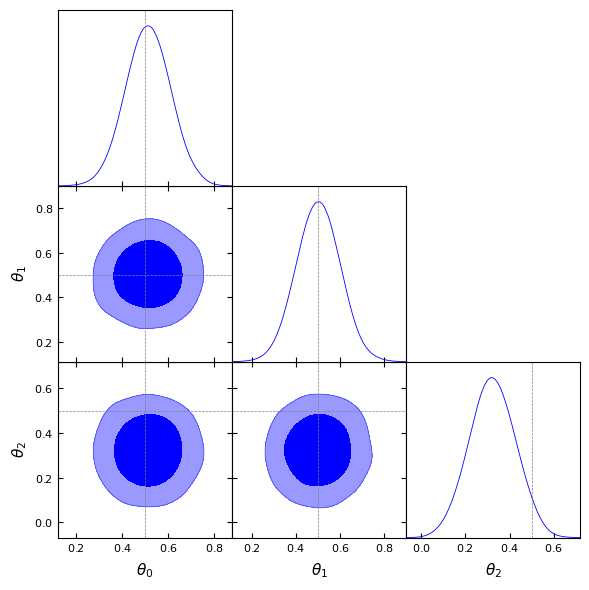

In [10]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

## Comparison with reference samples

This case is very simple so we can build a `numpyro` model to get reference samples of the posterior using HMC.

In [11]:
import numpyro

prior_dist = dist.Uniform(low=jnp.array([-2., -2., -2.]), high=jnp.array([2., 2., 2.]))

def model(data):
    theta = numpyro.sample("theta", prior_dist)

    z = numpyro.deterministic("z", theta)

    likelihood_distr = dist.Normal(loc=z, scale=0.1)
    likelihood = likelihood_distr.log_prob(data)
    numpyro.factor("log_likelihood", likelihood)

In [12]:
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=10_000)

mcmc.run(jax.random.PRNGKey(42), data=obs)

reference_samples = mcmc.get_samples()["theta"]

sample: 100%|██████████| 10500/10500 [00:32<00:00, 325.15it/s, 3 steps of size 9.53e-01. acc. prob=0.89] 


Removed no burn in
Removed no burn in


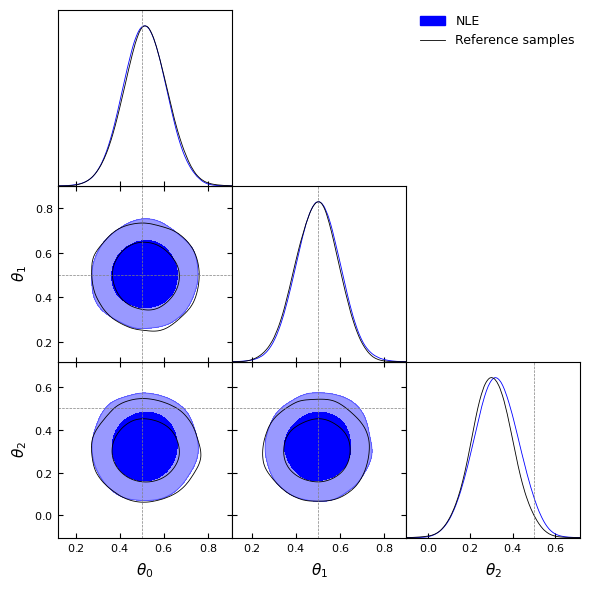

In [13]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)
reference_samples_gd = MCSamples(samples=reference_samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd, reference_samples_gd], filled=[True, False],
                line_args=[
                    {'color': 'blue'},
                    {'color': 'black'}
                ],
                legend_labels=['NLE', 'Reference samples'],
                contour_colors=['blue', 'black'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

We see here that our posterior samples are really close to the reference obtained using the true likelihood and MCMC sampling.

Let's also lay the stres on the fact the inference is also *amortized*. No training is required when using a different data vector!

## Next steps

In the following example, we will show how NPE and NLE perform on a more complex target posterior.